In [37]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use( 'bmh' ) 

In [38]:
import pandas 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np 
import pickle
from scipy.stats import pearsonr

# Feature sets 

This notebook collects the various feature sets from molecular modeling (in `*runs/*/feature_set.csv'`), and matches them up with the various targets (for now, melting temperature, turnover number, substrate affinity, and efficiency) for input to machine learning algorithms

In [39]:
feature_sets = [ 
    # rosetta 
    '../rosetta_runs/benchmark/feature_set.csv', 
    #'../rosetta_runs/shells/feature_set.csv',
    '../rosetta_runs/ddg_monomer/feature_set.csv', 
    #'../rosetta_runs/new_protocol/feature_set.csv', 
    #'../rosetta_runs/fresh/small_feature_set.csv', 
    
    # pyrosetta 
    #'../pyrosetta_runs/beta/feature_set.csv', 
    #'../pyrosetta_runs/beta2/feature_set.csv', 
    
    # foldx 
    '../foldx_runs/pssm/feature_set.csv', 
    
    # dreaming 
    # '../rosetta_runs/homology_models/feature_set.csv', 
]

In [40]:
#experimental_data 
dat = pandas.read_csv( '../data_sets/experimental/targets.csv', index_col=0 )
#dat.kcat = np.log10( dat.kcat / 880 )
#dat.km = np.log10( dat.km / 5.5 )
#dat.kcatkm = np.log10( dat.kcatkm / 174000 )
#dat = dat.replace( [ np.inf, -np.inf ], -5 )

In [41]:
dat.sample( 6 ) 

,expression,tm,kcat,km,kcatkm
mutant,,,,,
W407Q,0,NaN,NaN,NaN,NaN
N163D,1,-1.41,-1.865301,-0.482588,-2.343472
N293D,0,NaN,NaN,NaN,NaN
T175R,1,-1.87,-0.040850,0.143876,0.107820
E177L,1,-0.33,-0.118408,-0.174932,-0.288833
Q19A,1,NaN,NaN,NaN,-4.240549


In [42]:
targets = [ 'kcat', 'km', 'kcatkm', 'tm', 'expression' ] 

In [43]:
combos = []
for feature_set in feature_sets:
    
    # read in feature set 
    feats = pandas.read_csv( feature_set, index_col=0 )
    # short name for display 
    name = feature_set.split( '/' )[2]
    
    # join feature sets with targets 
    for target in targets:
        
        # join feature set with target and remove rows and columns with NaN entries 
        J = dat[[ target ]].join( feats ).dropna()
        print( J.shape, name, target )
        
        # calculate feature correlation to target while this is still a DataFrame
        corr_to_target = J.corr()[ target ].drop( target )  # pandas.Series 
        
        # scale the features to the [0,1] interval 
        #scaler = MinMaxScaler()
        scaler = StandardScaler()
        X = scaler.fit_transform( J )
        
        # get all columns except first one (first is target col) 
        X = X[ : , 1: ] 
        
        # reshape target to a 1-D array for sklearn 
        y = J.ix[ : , 0 ].ravel()
        
        # append a combo tuple 
        # include names of columns since the scaler returns an unlabeled NumPy array 
        support = J.columns[ 1: ] # feature names 
        combos.append( ( name, target, X, y, support, corr_to_target ) )

(73, 60) benchmark kcat
(73, 60) benchmark km
(87, 60) benchmark kcatkm
(76, 60) benchmark tm
(125, 60) benchmark expression
(73, 15) ddg_monomer kcat
(73, 15) ddg_monomer km
(88, 15) ddg_monomer kcatkm
(76, 15) ddg_monomer tm
(127, 15) ddg_monomer expression
(74, 17) pssm kcat
(74, 17) pssm km
(89, 17) pssm kcatkm
(77, 17) pssm tm
(128, 17) pssm expression


In [44]:
with open( 'combos.pkl', 'wb' ) as fn:
    pickle.dump( combos, fn ) 

## Feature distributions

Here, we attempt to make a compact representation of the feature ranges in the feature set. Each plot is titled with the feature set name and target name (each feature set has different mutants in it, depending on the target). Each feature has been normalized to the [0,1] interval. The number in parentheses after the feature name is the Pearson correlation coefficient for the individual feature to the target.

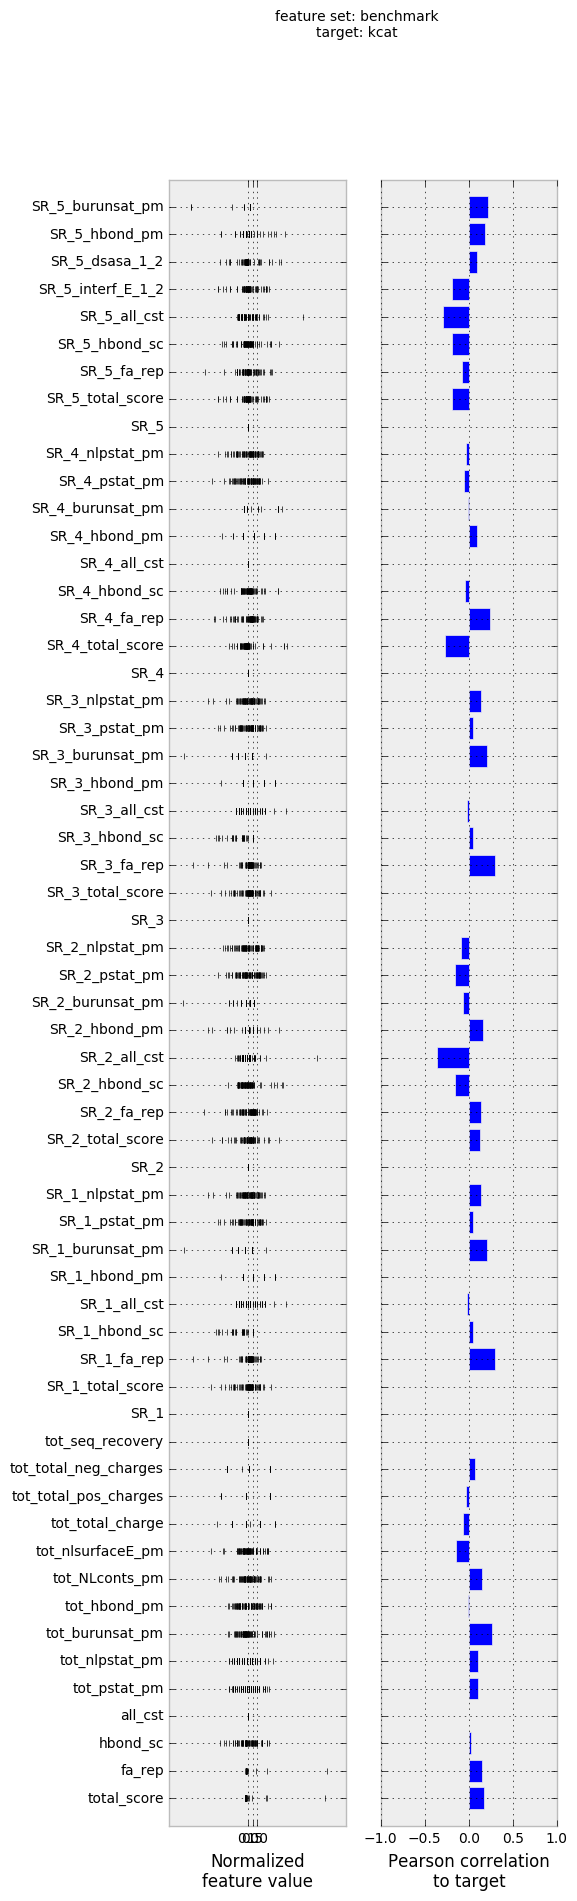

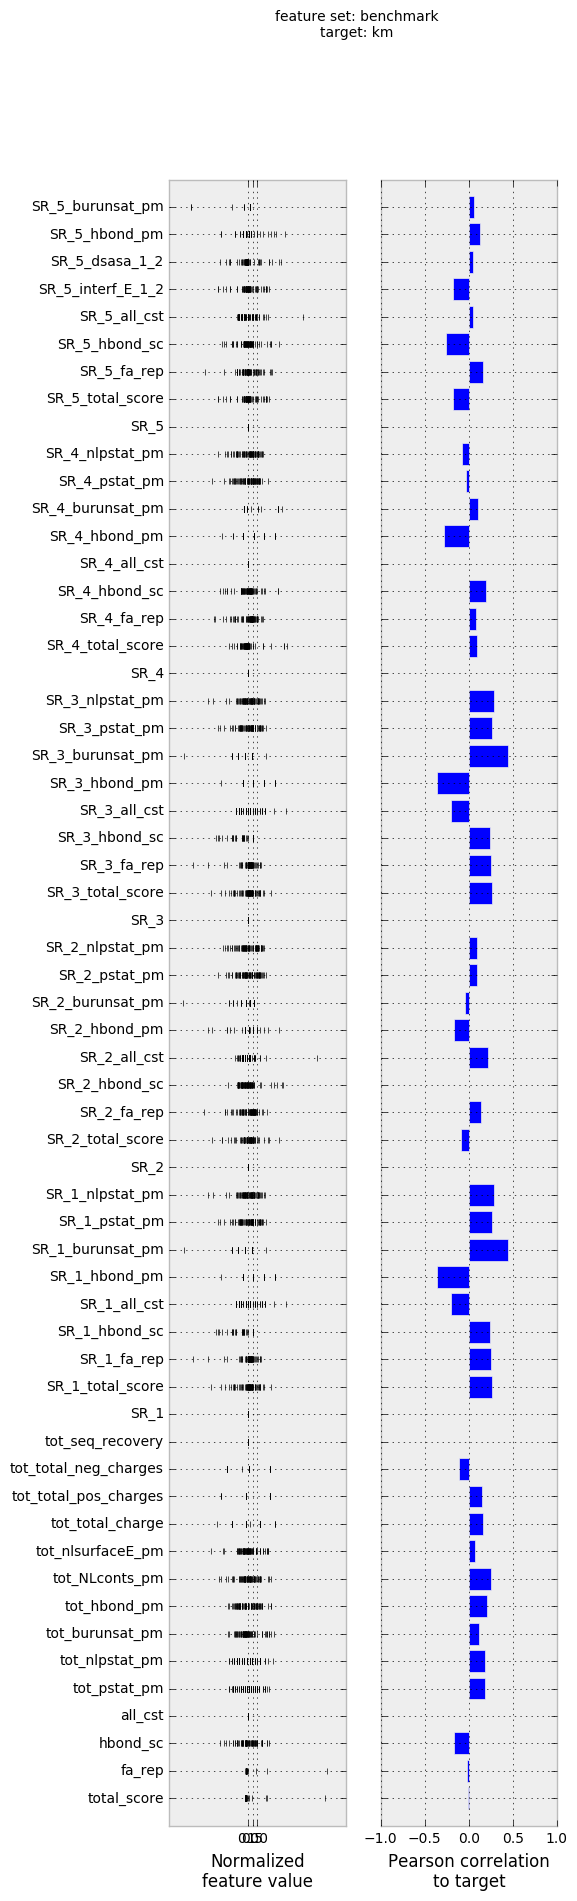

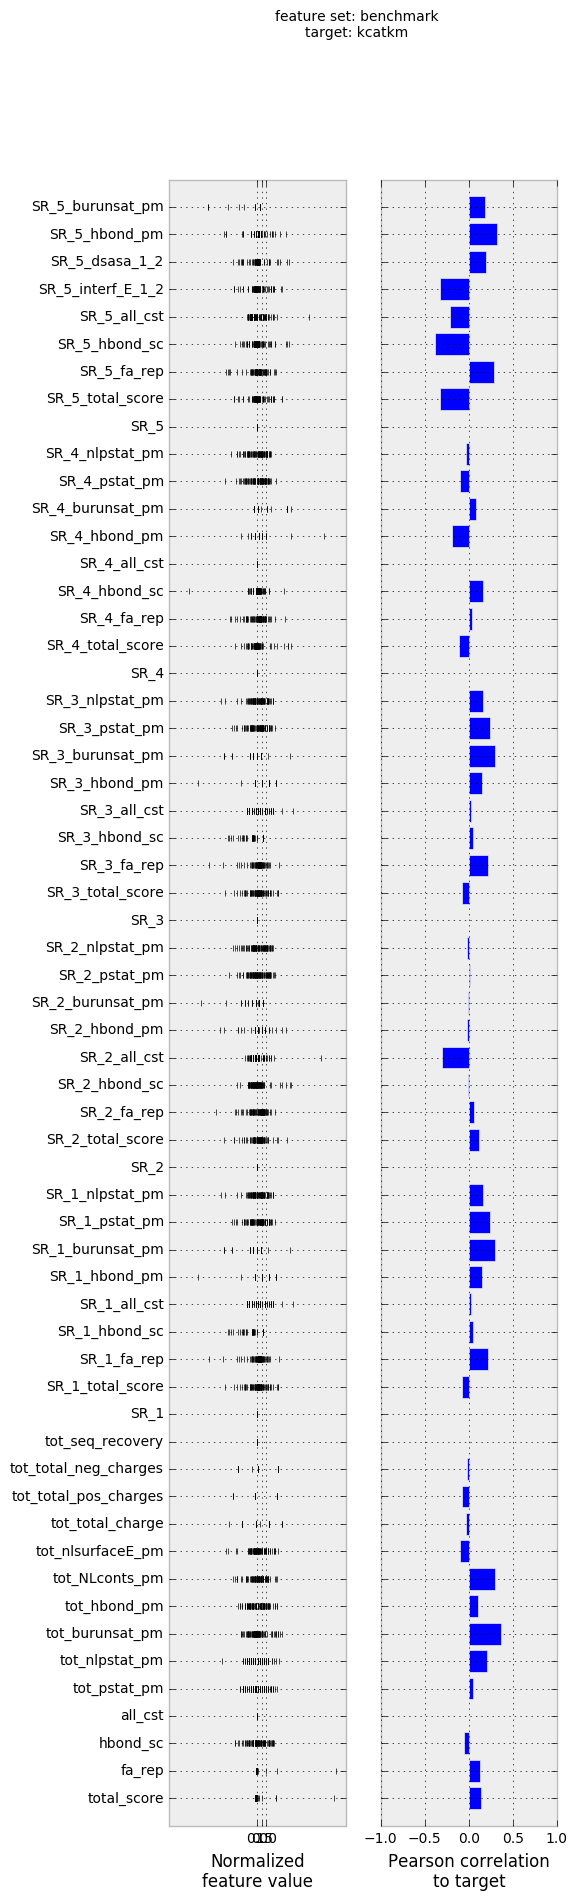

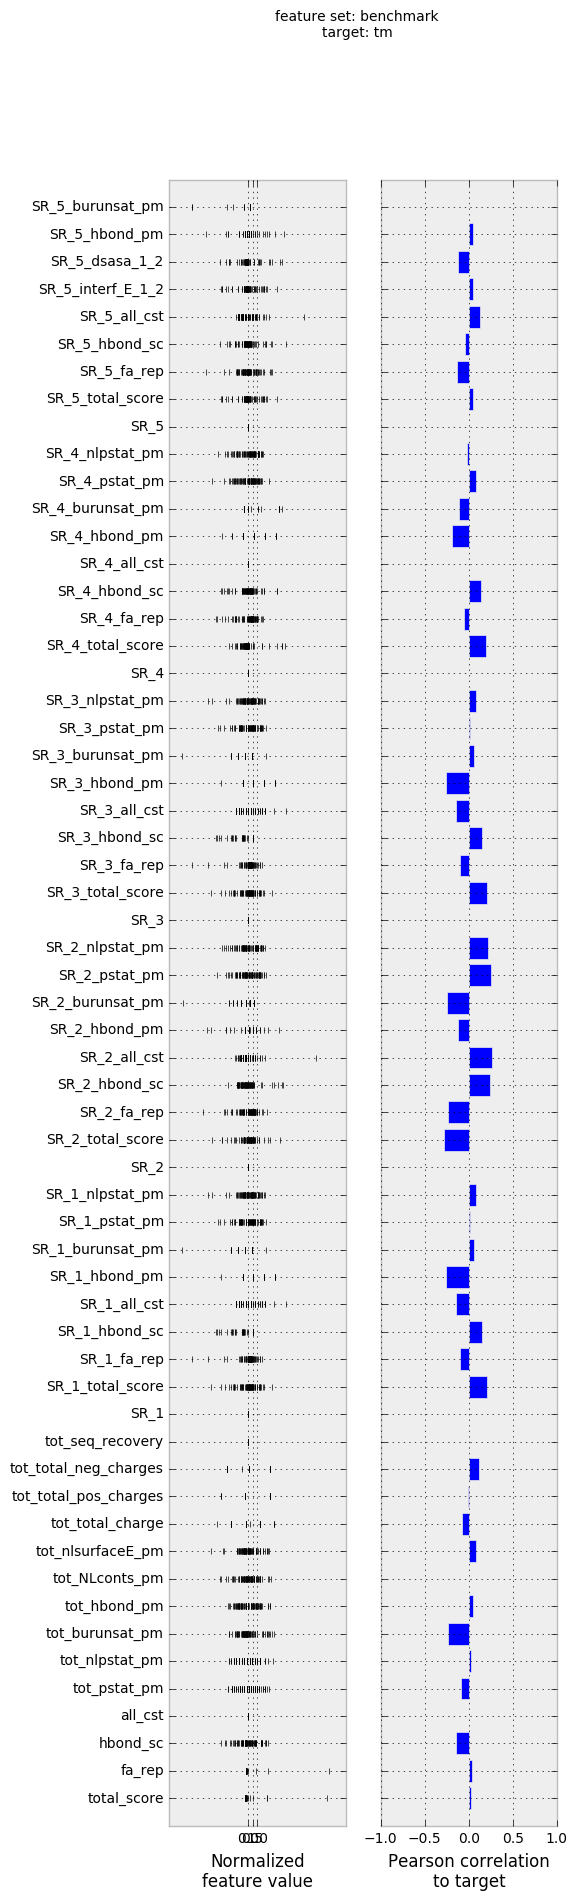

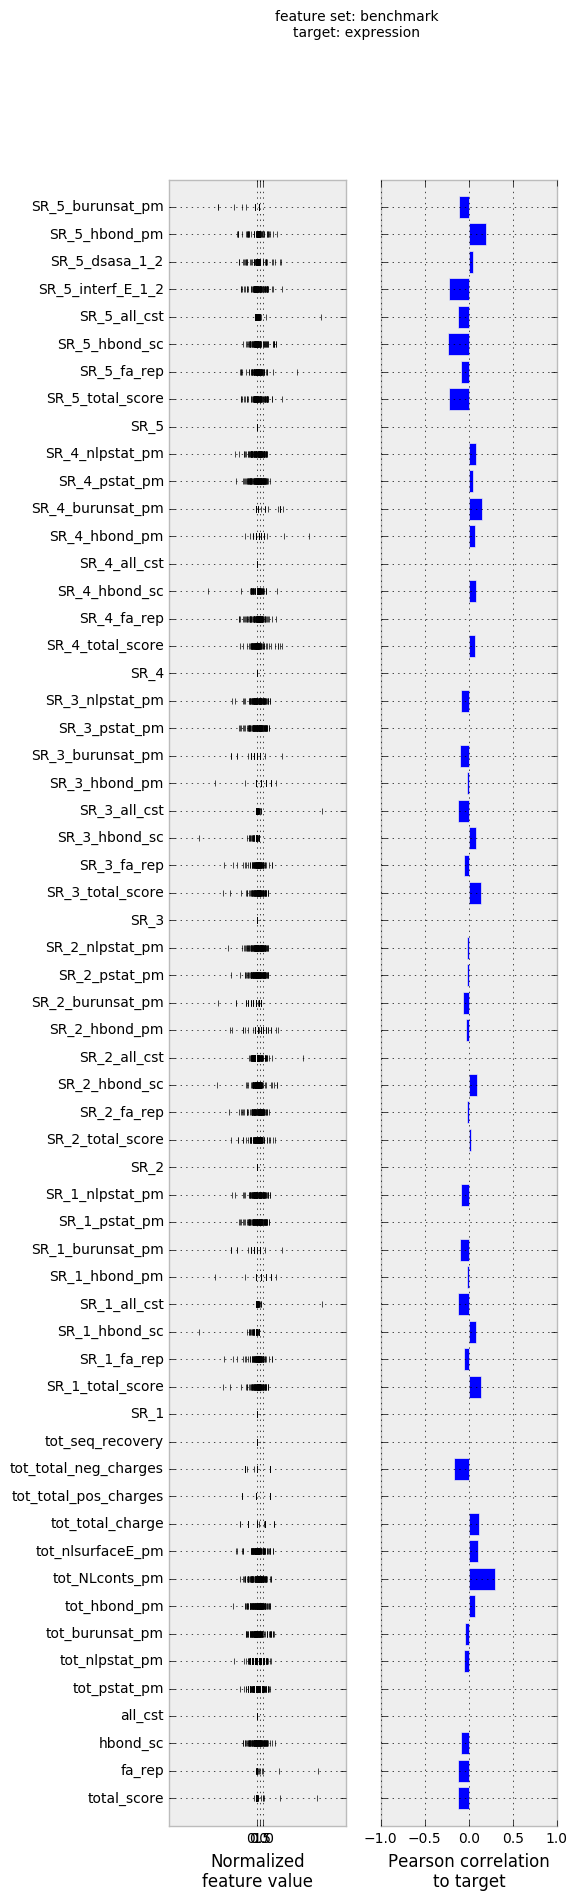

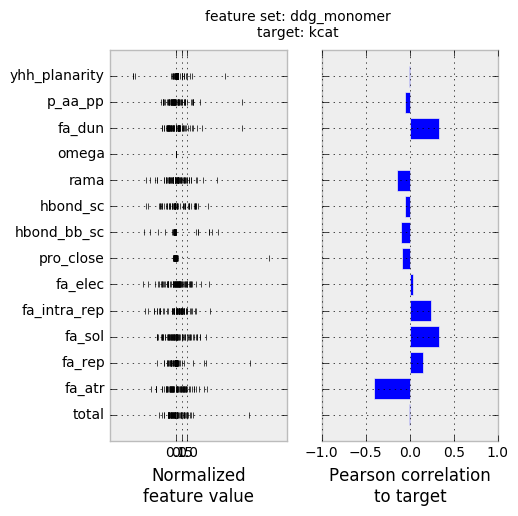

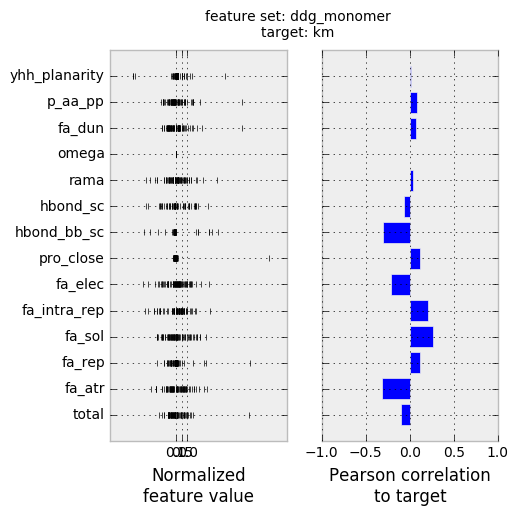

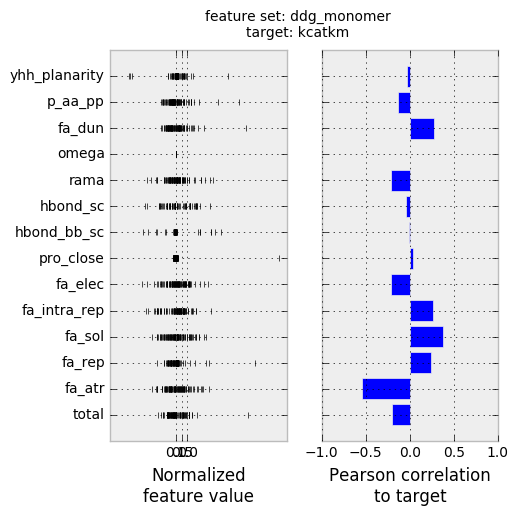

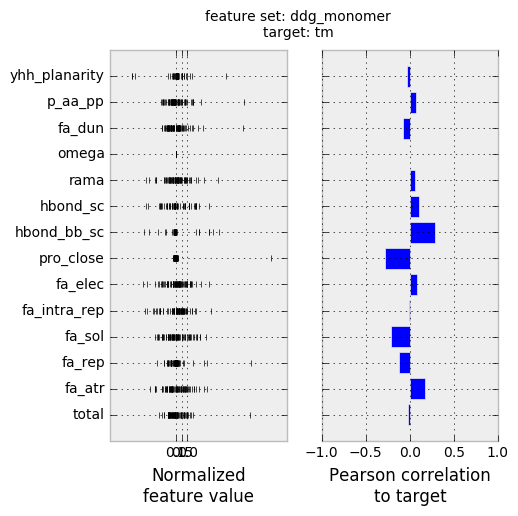

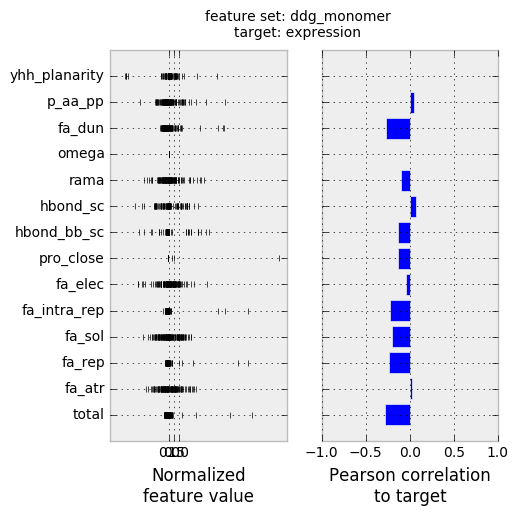

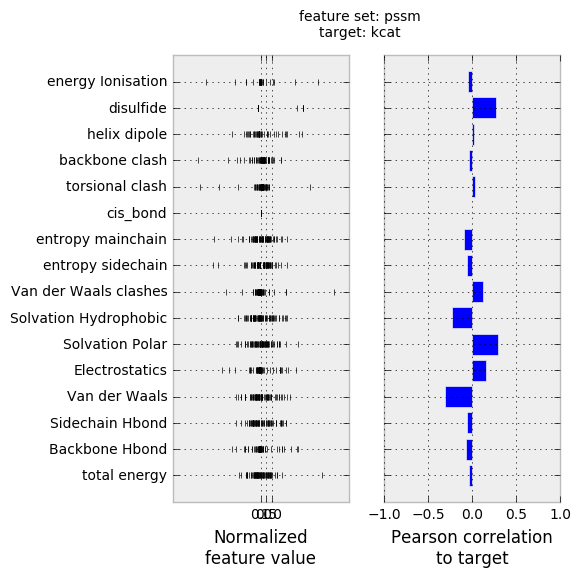

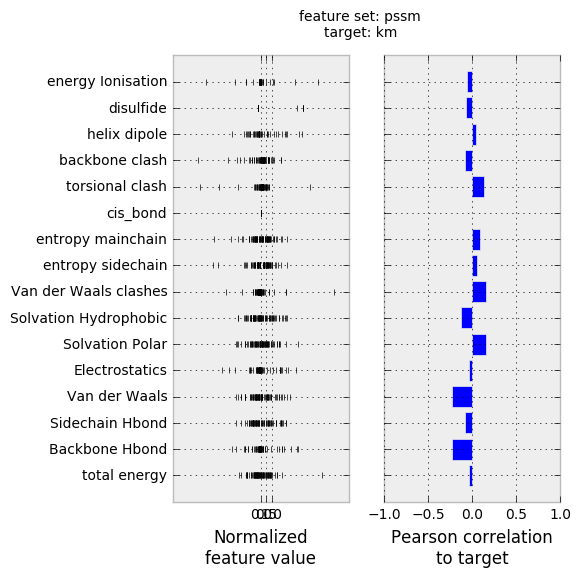

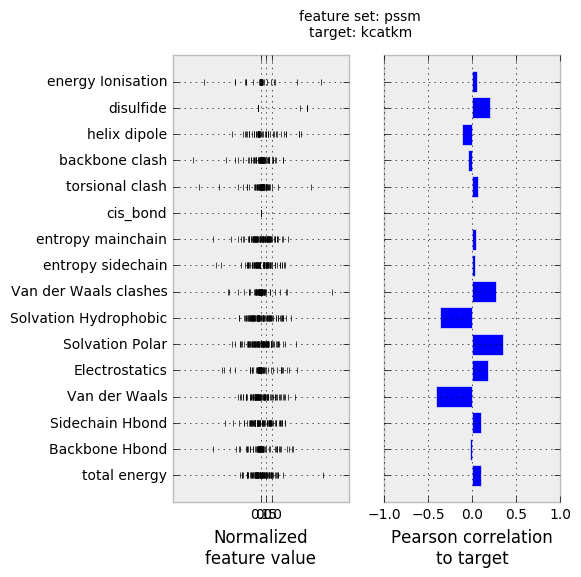

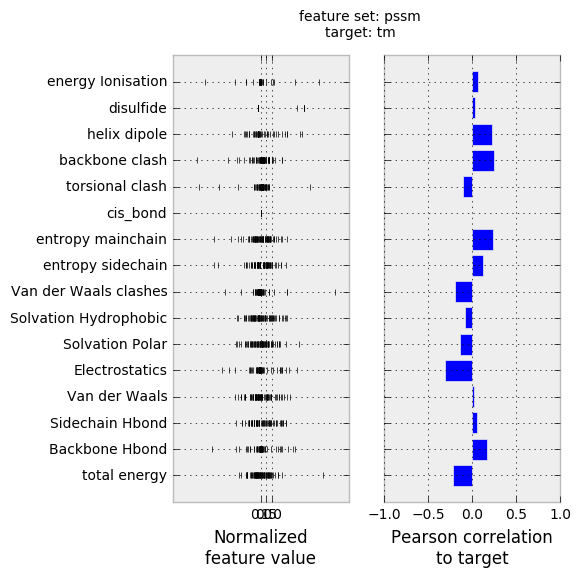

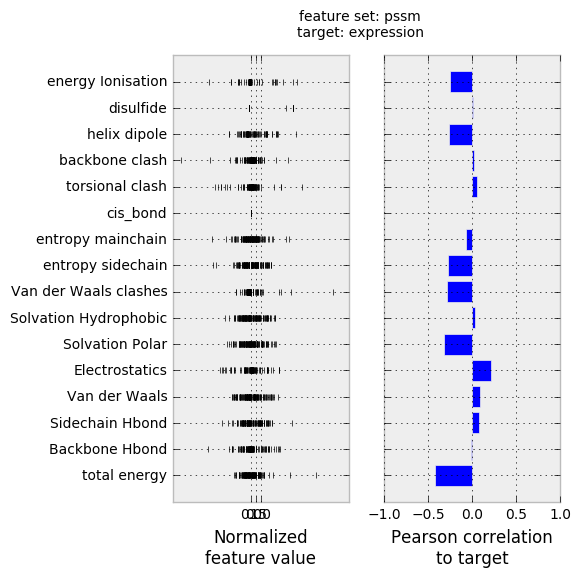

In [45]:
for name, target, X, y, support, corr_to_target in combos: 
    
    fig, ax = plt.subplots( nrows=1, ncols=2, sharey=True, figsize=( 5, 0.36 * len( support ) ) )
        
    support_vals = []
    rr = []
    for i, col_name in enumerate( support ):
        ax[ 0 ].scatter( X[ : , i ], [ i ] * len( X ), marker='|', color='k' )
        ax[ 0 ].set_ylim( -1, len( support ) )
        r, p = pearsonr( X[ : , i ], y )
        rr.append( r ) 
        #support_vals.append( '{} ({})'.format( col_name, r.round(2) ) )
        support_vals.append( '{}'.format( col_name ) )
        
    ax[ 0 ].set_yticks( range( len( support_vals ) ) )
    ax[ 0 ].set_yticklabels( support_vals )
    ax[ 0 ].set_xticks( ( 0, .5, 1 ) )
    ax[ 0 ].set_xlabel( 'Normalized\nfeature value' )
    
    ax[ 1 ].barh( range( len( support_vals ) ), rr, align='center' ) 
    ax[ 1 ].set_xlim( ( -1, 1 ) )
    ax[ 1 ].set_xlabel( 'Pearson correlation\nto target' )
    
    fig.suptitle( 'feature set: {}\ntarget: {}'.format( name, target ) )

## Single feature correlations

We will assess the correlation of each feature independent of the others to the given target. Then, we will make a scatter plot of that feature against the variable. We will do this for all the possible combinations of feature sets and targets. 

/usr/local/bin/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


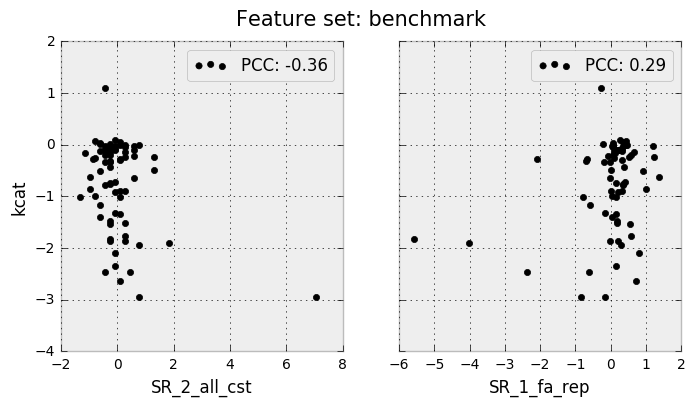

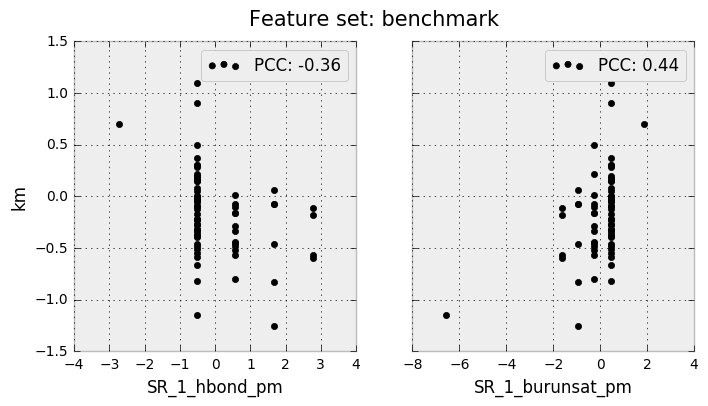

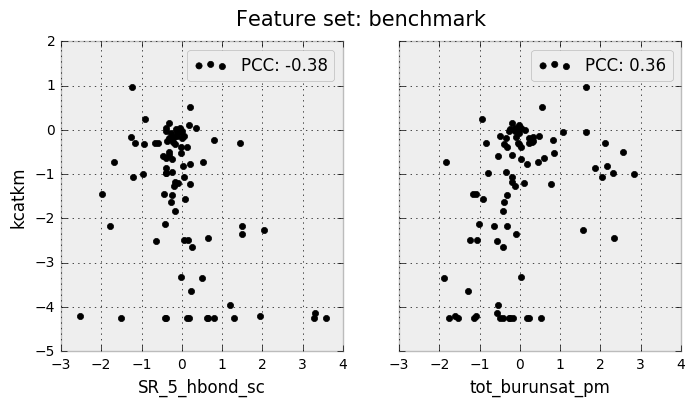

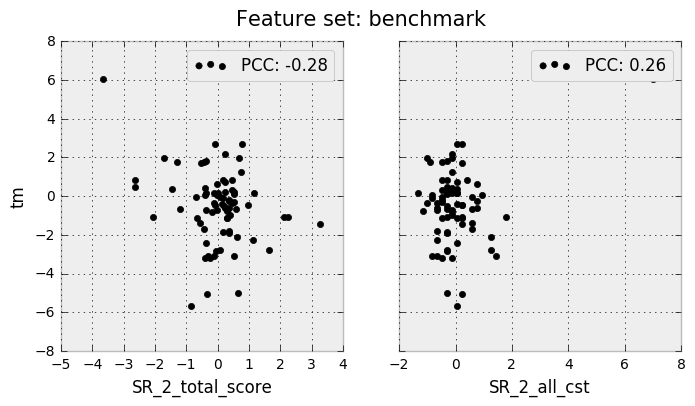

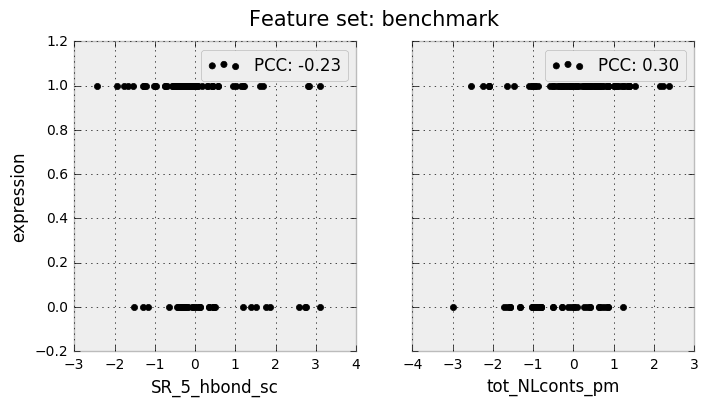

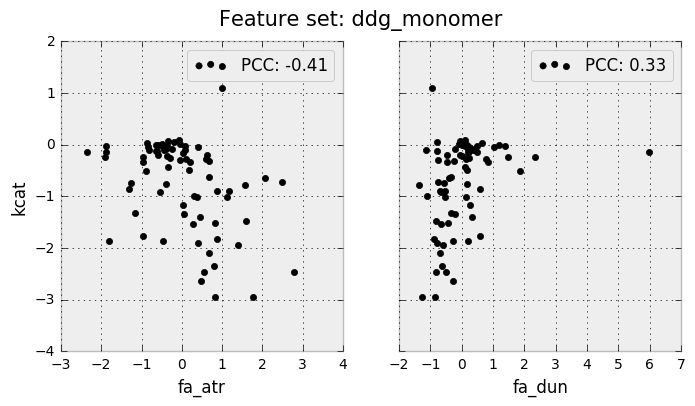

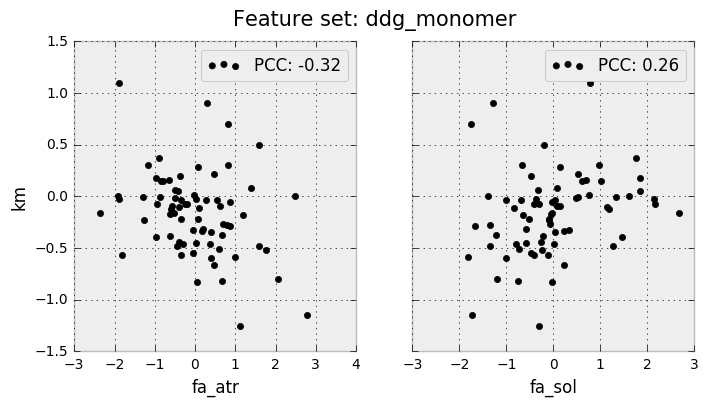

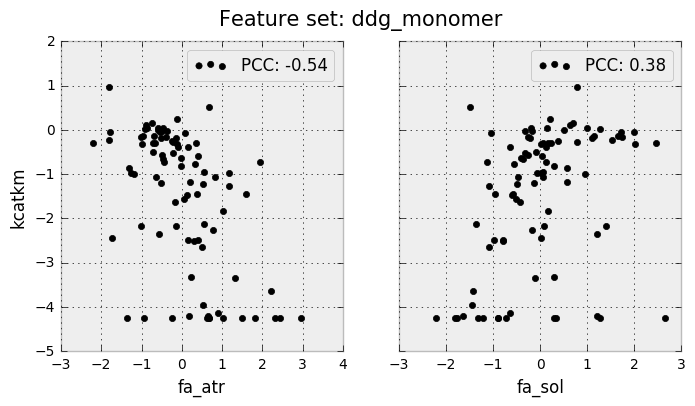

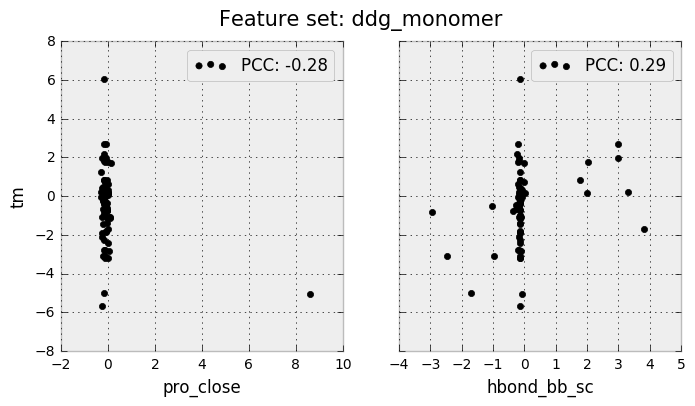

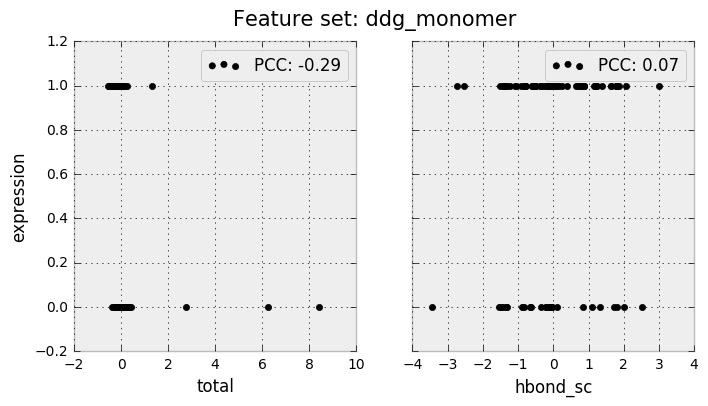

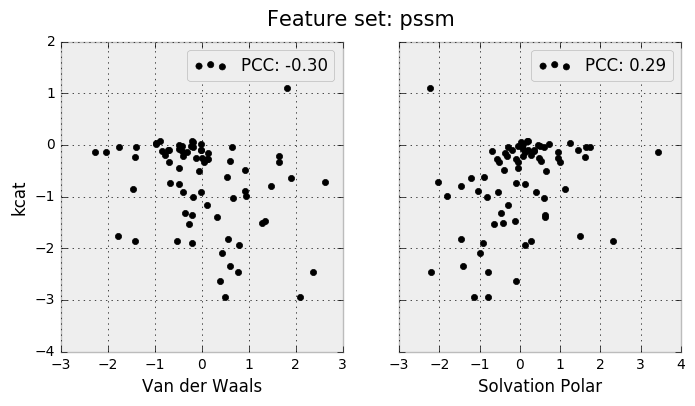

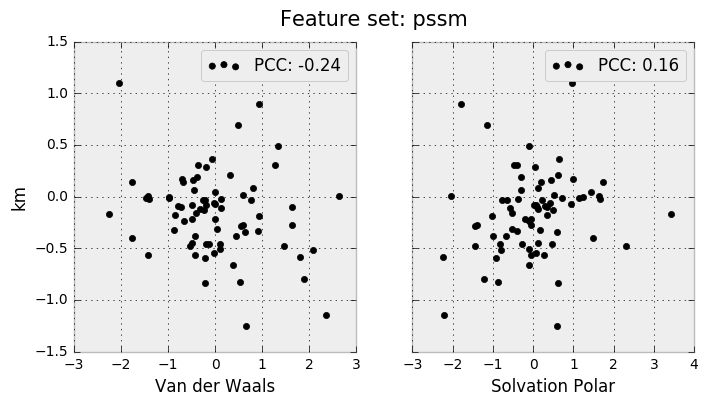

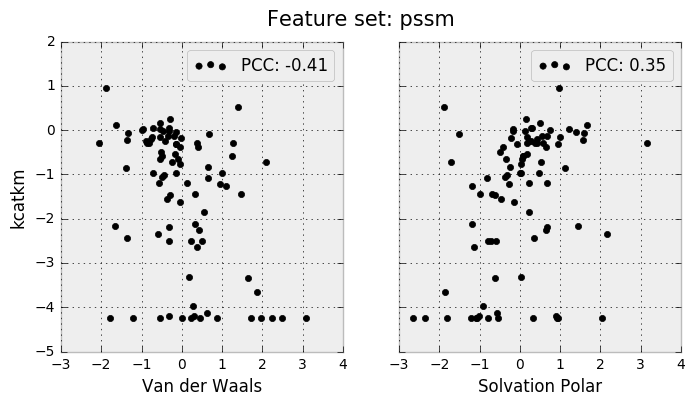

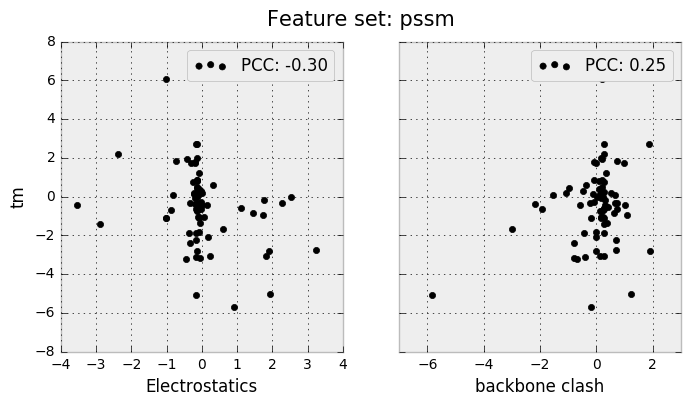

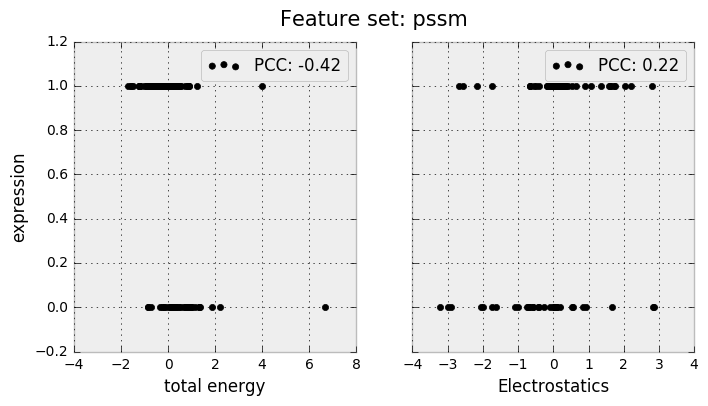

In [46]:
for name, target, X, y, support, corr_to_target in combos:

    df = pandas.DataFrame( X, columns=support ) 
    
    fig, ax = plt.subplots( nrows=1, ncols=2, sharey=True, figsize=(8,4) )
    fig.suptitle( 'Feature set: {}'.format( name ), fontsize=15 ) 
    title = 'Single best: {}\nPCC: {}\n'

    ax[0].scatter( df[ corr_to_target.idxmin() ], y, color='k' )
    ax[0].set_xlabel( corr_to_target.idxmin() ) 
    ax[0].set_ylabel( target ) 
    ax[0].legend( [ 'PCC: {0:2.2f}'.format( corr_to_target.min() ) ] ) 
                   
    ax[1].scatter( df[ corr_to_target.idxmax() ], y, color='k' )
    ax[1].set_xlabel( corr_to_target.idxmax() ) 
    ax[1].legend( [ 'PCC: {0:2.2f}'.format( corr_to_target.max() ) ] ) 

    fig.show()


## Next steps 

Now that we have an idea of the feature space, we can try training some machine learning algorithms to predict the experimental targets from the computational features. 

See notebooks `elastic_net`, `elastic_net_with_bagging`, and `predicting_soluble_expression` in this repo. 

### Secret feature set: benchmark including conservation 

Here, we'll include percent conservation based on PFAM, which is a readily-calculable feature, to see if incorporating molecular modeling and evolutionary information outperforms both.